In [1]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="staticrealanorouterdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [7]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

3client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
1client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy
2client_0attacker_infinite_requests_many_trials_realAstatic_norouterproxy


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,3client_0attacker_infinite_requests_many_trial...,3,21,2,receiver,pc3000,ubuntu1804-std
1,1client_0attacker_infinite_requests_many_trial...,3,6,4,proxy,microcloud,ubuntu1804-std
2,3client_0attacker_infinite_requests_many_trial...,3,15,3,attacker,pc3000,ubuntu1804-std
3,1client_0attacker_infinite_requests_many_trial...,3,3,6,client2,pc3000,ubuntu1804-std
4,2client_0attacker_infinite_requests_many_trial...,3,8,3,attacker,pc3000,ubuntu1804-std
5,3client_0attacker_infinite_requests_many_trial...,3,18,7,client3,pc3000,ubuntu1804-std
6,1client_0attacker_infinite_requests_many_trial...,3,5,1,originserver,pc2133,ubuntu1804-std
7,1client_0attacker_infinite_requests_many_trial...,3,1,3,attacker,pc3000,ubuntu1804-std
8,2client_0attacker_infinite_requests_many_trial...,3,12,1,originserver,pc2133,ubuntu1804-std
9,3client_0attacker_infinite_requests_many_trial...,3,16,5,client1,pc3000,ubuntu1804-std


In [17]:
client_rtt_sql = """
SELECT
	d.exp_id,
	n.node_name,
	e.trial,
	e.message_marker,
    COUNT(e.observe_timestamp) AS num_timestamps,
	1e3 * (MAX(e.observe_timestamp) - MIN(e.observe_timestamp)) AS message_rtt_ms,
    MAX(e.observe_timestamp) AS timestamp
FROM
	deployed_node d
	JOIN node n ON n.node_id = d.node_id
	JOIN event e ON e.observer_id = d.dnid
	JOIN experiment ex ON ex.exp_id = d.exp_id
WHERE
	n.node_name LIKE '%client%'
GROUP BY
	d.exp_id,
	n.node_name,
	e.trial,
	e.message_marker
"""

df = pd.read_sql_query(client_rtt_sql, con)
con.commit()

# Filter out bogus measurements
print(f"Dropping {len(df[df['num_timestamps'] != 2])} rows without 2 timestamps ({len(df)} total)")
df = df[df["num_timestamps"] == 2]

df

Dropping 18 rows without 2 timestamps (31733 total)


,exp_id,node_name,trial,message_marker,num_timestamps,message_rtt_ms,timestamp
0,1client_0attacker_infinite_requests_many_trial...,client1,1,1,2,193.212748,1.638461e+09
1,1client_0attacker_infinite_requests_many_trial...,client1,1,2,2,56.776047,1.638461e+09
2,1client_0attacker_infinite_requests_many_trial...,client1,1,3,2,55.321217,1.638461e+09
3,1client_0attacker_infinite_requests_many_trial...,client1,1,4,2,55.906057,1.638461e+09
4,1client_0attacker_infinite_requests_many_trial...,client1,1,5,2,56.671858,1.638461e+09
...,...,...,...,...,...,...,...
31727,3client_0attacker_infinite_requests_many_trial...,client3,3,5305,2,53.729057,1.638463e+09
31728,3client_0attacker_infinite_requests_many_trial...,client3,3,5306,2,53.699970,1.638463e+09
31729,3client_0attacker_infinite_requests_many_trial...,client3,3,5307,2,53.735971,1.638463e+09
31730,3client_0attacker_infinite_requests_many_trial...,client3,3,5308,2,53.444862,1.638463e+09


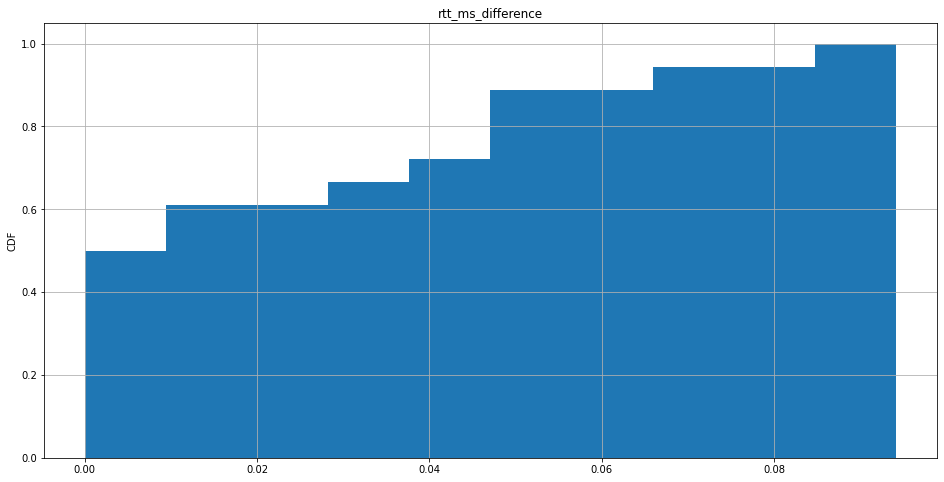

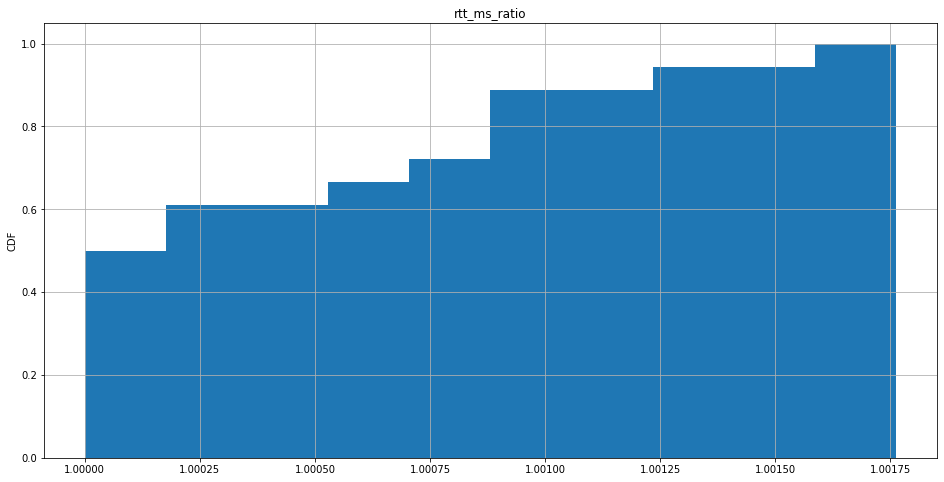

,exp_id,trial,client_min_rtt_ms,node_name,exp_min_rtt_ms,rtt_ms_difference,rtt_ms_ratio
0,1client_0attacker_infinite_requests_many_trial...,1,53.659916,client1,53.659916,0.000000,1.000000
1,1client_0attacker_infinite_requests_many_trial...,2,53.431988,client1,53.431988,0.000000,1.000000
2,1client_0attacker_infinite_requests_many_trial...,3,53.491831,client1,53.491831,0.000000,1.000000
3,2client_0attacker_infinite_requests_many_trial...,1,53.426981,client1,53.426981,0.000000,1.000000
4,2client_0attacker_infinite_requests_many_trial...,2,53.122997,client1,53.122997,0.000000,1.000000
5,2client_0attacker_infinite_requests_many_trial...,3,53.416967,client1,53.404808,0.012159,1.000228
6,2client_0attacker_infinite_requests_many_trial...,1,53.521156,client2,53.426981,0.094175,1.001763
7,2client_0attacker_infinite_requests_many_trial...,2,53.164959,client2,53.122997,0.041962,1.000790
8,2client_0attacker_infinite_requests_many_trial...,3,53.404808,client2,53.404808,0.000000,1.000000
9,3client_0attacker_infinite_requests_many_trial...,1,53.414822,client1,53.359032,0.055790,1.001046


In [18]:
# RTT in an experiment
exp_min_rtt_df = df.groupby(by=["exp_id", "trial"]).agg(
    exp_min_rtt_ms=('message_rtt_ms', 'min'),
)

client_rtt_df = df.groupby(by=["exp_id", "node_name", "trial"]).agg(
    client_min_rtt_ms=('message_rtt_ms', 'min'),
    node_name=('node_name', 'first')
)

rtt_comp_df = client_rtt_df.merge(exp_min_rtt_df, on=["exp_id", "trial"], how="left").reset_index()

rtt_comp_df["rtt_ms_difference"] = rtt_comp_df["client_min_rtt_ms"] - rtt_comp_df["exp_min_rtt_ms"]
rtt_comp_df["rtt_ms_ratio"] = rtt_comp_df["client_min_rtt_ms"] / rtt_comp_df["exp_min_rtt_ms"]

axs = []
axs.append(rtt_comp_df.hist(column="rtt_ms_difference", density=True, cumulative=True))
axs.append(rtt_comp_df.hist(column="rtt_ms_ratio", density=True, cumulative=True))

for _ax in axs:
    ax = _ax.flatten()[0]
    ax.set_ylabel("CDF")

plt.show()

rtt_comp_df

In [25]:
projected_rtt_comp_df = rtt_comp_df[["exp_id", "node_name", "trial", "client_min_rtt_ms"]]
normalize_rtt_df = df.merge(projected_rtt_comp_df, on=["exp_id", "node_name", "trial"])

# Normalize client RTT according to diff and pct
normalize_rtt_df["norm_rtt_diff"] = normalize_rtt_df["message_rtt_ms"] - normalize_rtt_df["client_min_rtt_ms"]
normalize_rtt_df["norm_rtt_ratio"] = normalize_rtt_df["message_rtt_ms"] / normalize_rtt_df["client_min_rtt_ms"]
normalize_rtt_df["norm_rtt_pct"] = 100 * (normalize_rtt_df["norm_rtt_ratio"] - 1)

normalize_rtt_df

,exp_id,node_name,trial,message_marker,num_timestamps,message_rtt_ms,timestamp,client_min_rtt_ms,norm_rtt_diff,norm_rtt_ratio,norm_rtt_pct
0,1client_0attacker_infinite_requests_many_trial...,client1,1,1,2,193.212748,1.638461e+09,53.659916,139.552832,3.600690,260.069046
1,1client_0attacker_infinite_requests_many_trial...,client1,1,2,2,56.776047,1.638461e+09,53.659916,3.116131,1.058072,5.807185
2,1client_0attacker_infinite_requests_many_trial...,client1,1,3,2,55.321217,1.638461e+09,53.659916,1.661301,1.030960,3.095981
3,1client_0attacker_infinite_requests_many_trial...,client1,1,4,2,55.906057,1.638461e+09,53.659916,2.246141,1.041859,4.185883
4,1client_0attacker_infinite_requests_many_trial...,client1,1,5,2,56.671858,1.638461e+09,53.659916,3.011942,1.056130,5.613020
...,...,...,...,...,...,...,...,...,...,...,...
31710,3client_0attacker_infinite_requests_many_trial...,client3,3,5305,2,53.729057,1.638463e+09,53.310871,0.418186,1.007844,0.784429
31711,3client_0attacker_infinite_requests_many_trial...,client3,3,5306,2,53.699970,1.638463e+09,53.310871,0.389099,1.007299,0.729868
31712,3client_0attacker_infinite_requests_many_trial...,client3,3,5307,2,53.735971,1.638463e+09,53.310871,0.425100,1.007974,0.797399
31713,3client_0attacker_infinite_requests_many_trial...,client3,3,5308,2,53.444862,1.638463e+09,53.310871,0.133991,1.002513,0.251339


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<IPython.core.display.Javascript object>


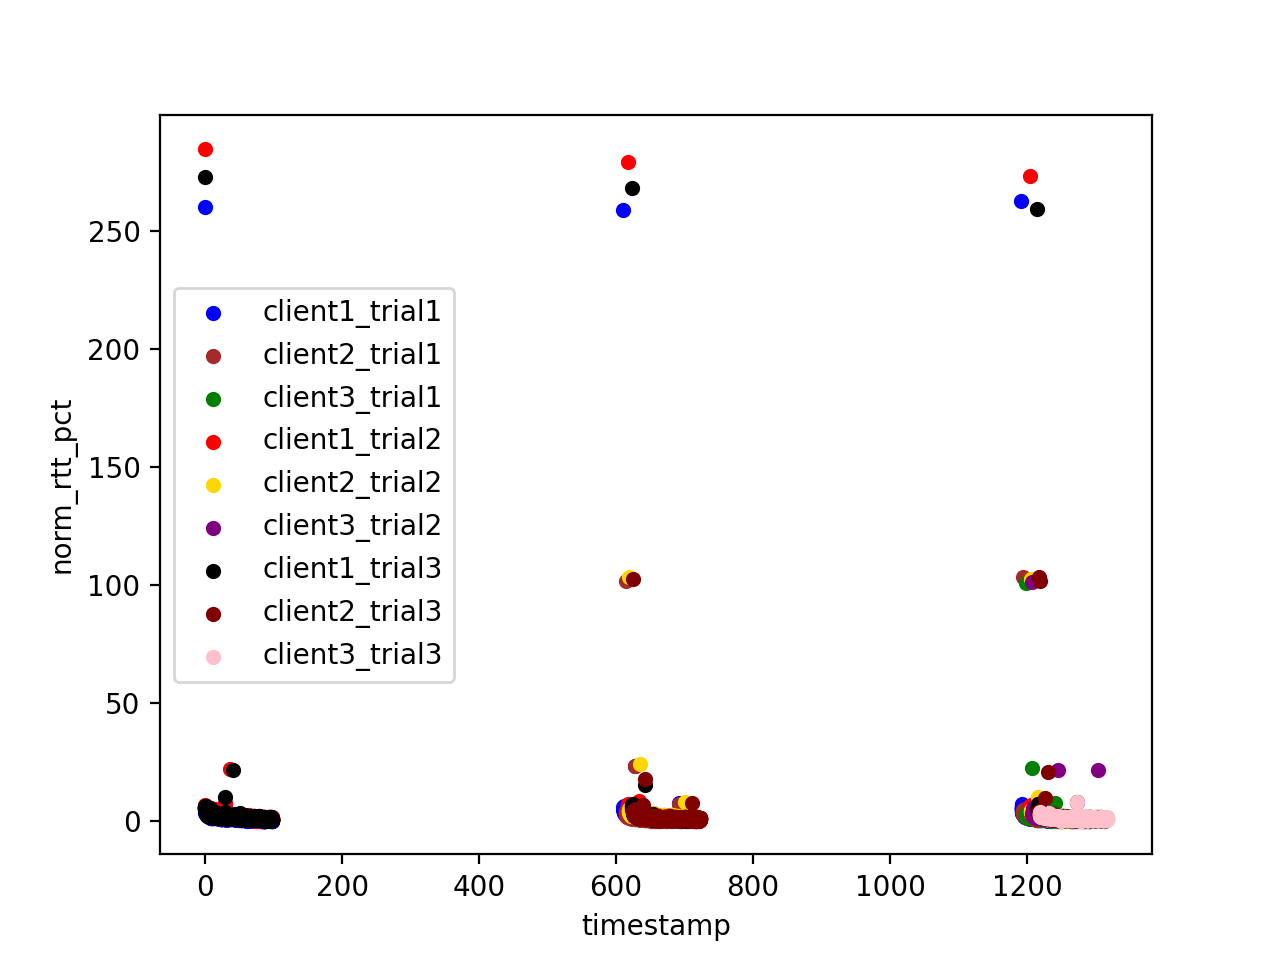

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
%matplotlib notebook

rtts_df = normalize_rtt_df

ignore_clients = {}
ignore_trials = {}

ax = None
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["timestamp"].min()
    trial_df["timestamp"] -= min_timestamp
    for client_number, src_id in enumerate(trial_df["node_name"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["node_name"] == src_id]
        label = f"client{client_number}_trial{t}"
        if ax:
            client_trial_df.plot(kind="scatter", x="timestamp", y="norm_rtt_pct", label=label, ax=ax, color=color_map[(client_number, t)])
        else:
            ax = client_trial_df.plot(kind="scatter", x="timestamp", y="norm_rtt_pct", label=label, color=color_map[(client_number, t)])
plt.show()